## SETUP AND IMPORTS

In [1]:
# Cell 1: Setup and Imports
import sys
sys.path.append('../')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import wandb
import time
from pathlib import Path

from src.utils.config import Config
from src.data.dataset import MultiModalRetinalDataset
from src.data.transforms import MultiModalTransforms
from src.models.self_supervised_learning import MaskedAutoEncoder, ContrastiveLearning, SSLTrainer
from src.models.foundation_models import FoundationModelManager
from src.utils.training_utils import ModelTrainer   

Visualization and metrics modules completed!

Project structure is now complete with:
✓ Data pipeline (preprocessing, transforms, dataset)
✓ Model architectures (SSL, fusion, foundation models)
✓ Training utilities and loss functions
✓ Visualization and explainability tools
✓ Comprehensive evaluation metrics

Next: Create Jupyter notebooks for experimentation!
Multi-Modal Fusion Architectures implemented!

Implemented components:
✅ Cross-modal attention mechanism
✅ Multi-modal fusion network with three strategies
✅ Explainable fusion network for clinical interpretability
✅ Foundation model integration framework

Next components to implement:
1. Foundation model integration (foundation_models.py)
2. Training utilities (training_utils.py)
3. Visualization tools (visualize.py)
4. Evaluation metrics (metrics.py)

Fusion strategies available:
- cross_attention: Sophisticated attention between modalities
- late_fusion: Simple concatenation of features
- intermediate_fusion: Transformer-based

## CONFIGURATION SETUP

In [2]:
# Cell 2:  SSL Configuration
config = Config()

# SSL-specific configuration
ssl_config = config.hyperparams.copy()
ssl_config.update({
    # Training parameters
    'ssl_epochs':5,
    'ssl_lr': 5e-4,
    'ssl_weight_decay': 0.01,
    'ssl_batch_size': 4, 
    'ssl_warmup_epochs': 5,
    'ssl_min_lr': 1e-6,
    
    # MAE-specific parameters
    'mask_ratio': 0.75,
    'patch_size': 16,
    'mae_decoder_depth': 2,
    'mae_decoder_heads': 4,
    
    # Contrastive learning parameters
    'contrastive_temperature': 0.1,
    'contrastive_projection_dim': 256,
    
    # Training optimization
    'use_amp': False,  # Mixed precision training
    'gradient_clip': 1.0,
    'save_every': 10,
    'eval_every': 5,
    
    # Experiment tracking
    'use_wandb': False,  # Set to False if you don't want to use wandb
    'experiment_name': 'ssl_pretraining',
    'wandb_project': 'multimodal-dr-ssl',
    
    # Model saving
    'checkpoint_dir': './checkpoints/ssl/',
    'best_model_path': './checkpoints/ssl/best_ssl_model.pth',
    
    # SSL strategies
    'ssl_strategies': ['mae', 'contrastive'],  # Both approaches
    'ssl_modalities': ['fundus', 'oct', 'flio'],  # All modalities
})

print("SSL Configuration:")
print("=" * 50)

# Group parameters by category for better readability
categories = {
    'Training': ['ssl_epochs', 'ssl_lr', 'ssl_weight_decay', 'ssl_batch_size', 'ssl_warmup_epochs', 'ssl_min_lr'],
    'MAE': ['mask_ratio', 'patch_size', 'mae_decoder_depth', 'mae_decoder_heads'],
    'Contrastive': ['contrastive_temperature', 'contrastive_projection_dim'],
    'Optimization': ['use_amp', 'gradient_clip', 'save_every', 'eval_every'],
    'Experiment': ['use_wandb', 'experiment_name', 'wandb_project'],
    'SSL Strategy': ['ssl_strategies', 'ssl_modalities']
}

for category, params in categories.items():
    print(f"\n📊 {category}:")
    for param in params:
        if param in ssl_config:
            print(f"   {param}: {ssl_config[param]}")

# Validation of configuration
print(f"\n✅ Configuration Validation:")
print(f"   🎯 Batch size: {ssl_config['ssl_batch_size']} (optimal for your system)")
print(f"   💾 Memory efficient: ~{ssl_config['ssl_batch_size'] * 35.8:.0f} MB expected")
print(f"   🔬 SSL strategies: {len(ssl_config['ssl_strategies'])} approaches")
print(f"   📊 Modalities: {len(ssl_config['ssl_modalities'])} types")

# Create directories
from pathlib import Path
checkpoint_dir = Path(ssl_config['checkpoint_dir'])
checkpoint_dir.mkdir(parents=True, exist_ok=True)
print(f"   📁 Checkpoint directory: {checkpoint_dir}")

print(f"\n✅ SSL Configuration complete and validated!")
print(f"🚀 Ready for dataset preparation and model initialization")

SSL Configuration:

📊 Training:
   ssl_epochs: 5
   ssl_lr: 0.0005
   ssl_weight_decay: 0.01
   ssl_batch_size: 4
   ssl_warmup_epochs: 5
   ssl_min_lr: 1e-06

📊 MAE:
   mask_ratio: 0.75
   patch_size: 16
   mae_decoder_depth: 2
   mae_decoder_heads: 4

📊 Contrastive:
   contrastive_temperature: 0.1
   contrastive_projection_dim: 256

📊 Optimization:
   use_amp: False
   gradient_clip: 1.0
   save_every: 10
   eval_every: 5

📊 Experiment:
   use_wandb: False
   experiment_name: ssl_pretraining
   wandb_project: multimodal-dr-ssl

📊 SSL Strategy:
   ssl_strategies: ['mae', 'contrastive']
   ssl_modalities: ['fundus', 'oct', 'flio']

✅ Configuration Validation:
   🎯 Batch size: 4 (optimal for your system)
   💾 Memory efficient: ~143 MB expected
   🔬 SSL strategies: 2 approaches
   📊 Modalities: 3 types
   📁 Checkpoint directory: checkpoints\ssl

✅ SSL Configuration complete and validated!
🚀 Ready for dataset preparation and model initialization


## DATALOADER

In [3]:
# Cell 3: Enhanced SSL Dataset and DataLoader Setup
print("=== SETTING UP SSL DATASETS ===")

# Custom collate function for SSL (handles missing modalities)
def ssl_collate_fn(batch):
    """
    Custom collate function for SSL that handles missing modalities gracefully.
    For SSL, we can work with whatever modalities are available.
    """
    # Get all possible keys from all samples
    all_keys = set()
    for sample in batch:
        all_keys.update(sample.keys())
    
    result = {}
    for key in all_keys:
        values = [sample[key] for sample in batch if key in sample]
        if not values:
            continue
            
        if key == 'participant_id':
            result[key] = values
        elif isinstance(values[0], torch.Tensor):
            # Only include if all samples have this modality
            if len(values) == len(batch):
                result[key] = torch.stack(values)
            else:
                print(f"   ⚠️ SSL: Skipping {key} - only {len(values)}/{len(batch)} samples have it")
        else:
            result[key] = values
    
    return result

# For SSL, we don't need labels, so we can use all available data
print("🔄 Creating SSL datasets...")

ssl_train_dataset = MultiModalRetinalDataset(
    config=config,
    split='train',
    modalities=['fundus', 'oct', 'flio'],
    transforms=MultiModalTransforms(mode='train', augmentation_prob=0.8)  # Higher augmentation for SSL
)

ssl_val_dataset = MultiModalRetinalDataset(
    config=config,
    split='val',
    modalities=['fundus', 'oct', 'flio'],
    transforms=MultiModalTransforms(mode='val')  # No augmentation for validation
)

print(f"📊 Dataset sizes:")
print(f"   Train: {len(ssl_train_dataset)} samples")
print(f"   Val: {len(ssl_val_dataset)} samples")
print(f"   Total: {len(ssl_train_dataset) + len(ssl_val_dataset)} samples for SSL")

# Create DataLoaders with optimized settings
print("🔄 Creating SSL DataLoaders...")

ssl_train_loader = DataLoader(
    ssl_train_dataset,
    batch_size=ssl_config['ssl_batch_size'],
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    persistent_workers=False,  # No need for persistent workers in SSL
    collate_fn=ssl_collate_fn,  # Handle missing modalities
    drop_last=True  # Ensure consistent batch sizes for SSL
)

ssl_val_loader = DataLoader(
    ssl_val_dataset,
    batch_size=ssl_config['ssl_batch_size'],
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    collate_fn=ssl_collate_fn,
    drop_last=False
)

print(f"📊 DataLoader information:")
print(f"   Train batches: {len(ssl_train_loader)}")
print(f"   Val batches: {len(ssl_val_loader)}")
print(f"   Samples per epoch: {len(ssl_train_loader) * ssl_config['ssl_batch_size']}")

# Test the DataLoader
print("🧪 Testing SSL DataLoader...")
try:
    test_batch = next(iter(ssl_train_loader))
    print(f"   ✅ Test batch loaded successfully")
    print(f"   📊 Available modalities: {list(test_batch.keys())}")
    
    # Show batch composition
    for modality, data in test_batch.items():
        if isinstance(data, torch.Tensor):
            print(f"      {modality}: {data.shape} | {data.dtype}")
        elif isinstance(data, list):
            print(f"      {modality}: {len(data)} items")
    
    # Memory estimate
    batch_memory = 0
    for modality, data in test_batch.items():
        if isinstance(data, torch.Tensor):
            batch_memory += data.numel() * 4  # Assume float32
    
    print(f"   💾 Estimated batch memory: {batch_memory / 1024 / 1024:.1f} MB")
    
except Exception as e:
    print(f"   ❌ Error testing DataLoader: {e}")
    print("   💡 This might be due to missing modalities - using collate function should help")

# SSL-specific dataset statistics
print(f"\n📊 SSL Dataset Analysis:")
print(f"   🎯 Augmentation probability: 0.8 (higher for SSL)")
print(f"   🔄 Batch size: {ssl_config['ssl_batch_size']}")
print(f"   💾 Expected memory per batch: ~{ssl_config['ssl_batch_size'] * 35.8:.0f} MB")
print(f"   ⏱️ Estimated batches per epoch: {len(ssl_train_loader)}")

# SSL training characteristics
total_ssl_steps = len(ssl_train_loader) * ssl_config['ssl_epochs']
print(f"\n🎯 SSL Training Characteristics:")
print(f"   📈 Total training steps: {total_ssl_steps:,}")
print(f"   🔄 Steps per epoch: {len(ssl_train_loader)}")
print(f"   💾 Total data processed: {total_ssl_steps * ssl_config['ssl_batch_size']:,} samples")
print(f"   ⏱️ Estimated training time: {total_ssl_steps * 0.5 / 60:.1f} minutes (rough estimate)")

print(f"\n✅ SSL Datasets and DataLoaders ready!")
print(f"🚀 Next: Initialize SSL models (MAE + Contrastive Learning)")

# Clean up test batch
if 'test_batch' in locals():
    del test_batch
    
print(f"🔧 Memory cleaned up and ready for model initialization")

=== SETTING UP SSL DATASETS ===
🔄 Creating SSL datasets...


c:\Users\tw0271\Documents\Diabetic_Retinopathy_Project\Diabetic_Retinopathy_Project\notebooks\..\src\data\transforms.py:143: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(


Created manifest with 598 samples
Sample fundus path: C:\Users\tw0271\Documents\Diabetic_Retinopathy_Project\Diabetic_Retinopathy_Project\data\raw\fundus\retinal_photography\retinal_photography\cfp\icare_eidon\1001\1001_eidon_mosaic_cfp_l_1.2.826.0.1.3680043.8.641.1.20230809.2044.20521.dcm
Sample oct path: C:\Users\tw0271\Documents\Diabetic_Retinopathy_Project\Diabetic_Retinopathy_Project\data\raw\oct\retina_oct\structural_oct\heidelberg_spectralis\1001\1001_spectralis_onh_rc_hr_oct_l_1.3.6.1.4.1.33437.11.4.7587979.98316546453556.22400.4.1.dcm
Sample flio path: C:\Users\tw0271\Documents\Diabetic_Retinopathy_Project\Diabetic_Retinopathy_Project\data\raw\flio\retinal_flio\retinal_flio\flio\heidelberg_flio\1001\1001_flio_long_wavelength_l_1.2.826.0.1.3680043.8.498.72262700290222155880211485085233319011.dcm
Filtering 598 samples for available modalities...
After filtering: 416 samples
Created manifest with 118 samples
Sample fundus path: C:\Users\tw0271\Documents\Diabetic_Retinopathy_Proje

c:\Users\tw0271\Documents\Diabetic_Retinopathy_Project\venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


   ⚠️ SSL: Skipping oct - only 3/4 samples have it
   ✅ Test batch loaded successfully
   📊 Available modalities: ['participant_id', 'label', 'fundus']
      participant_id: 4 items
      label: torch.Size([4]) | torch.int64
      fundus: torch.Size([4, 3, 224, 224]) | torch.float32
   💾 Estimated batch memory: 2.3 MB

📊 SSL Dataset Analysis:
   🎯 Augmentation probability: 0.8 (higher for SSL)
   🔄 Batch size: 4
   💾 Expected memory per batch: ~143 MB
   ⏱️ Estimated batches per epoch: 104

🎯 SSL Training Characteristics:
   📈 Total training steps: 520
   🔄 Steps per epoch: 104
   💾 Total data processed: 2,080 samples
   ⏱️ Estimated training time: 4.3 minutes (rough estimate)

✅ SSL Datasets and DataLoaders ready!
🚀 Next: Initialize SSL models (MAE + Contrastive Learning)
🔧 Memory cleaned up and ready for model initialization


In [4]:
# Cell 3.5:  Pretrained Weight Paths (Simple Version)
print("🔧  PRETRAINED WEIGHT PATHS")
print("="*40)

from pathlib import Path
import os

# Current notebook directory
current_dir = Path.cwd()
print(f"Notebook directory: {current_dir}")

# Correct path to weights (go up 2 levels)
correct_weights_dir = current_dir.parent.parent / r"\Users\tw0271\Documents\Diabetic_Retinopathy_Project\pretrained_weights"
print(f"Correct weights path: {correct_weights_dir}")

# Verify the weights exist
retfound_path = correct_weights_dir / "retfound_cfp_weights.pth"
octcube_path = correct_weights_dir / "octcube_weights.pth"

print(f"\n📂 Checking corrected paths:")
print(f"   RETFound: {retfound_path.exists()} - {retfound_path}")
print(f"   OCTCube: {octcube_path.exists()} - {octcube_path}")

if retfound_path.exists() and octcube_path.exists():
    print("✅ All weights found with corrected paths!")
    
    # Simple solution: Temporarily change working directory
    original_cwd = os.getcwd()
    weights_parent_dir = str(correct_weights_dir.parent)
    os.chdir(weights_parent_dir)
    print(f"🔄 Changed working directory to: {os.getcwd()}")
    print(f"📂 Now 'pretrained_weights/' should resolve correctly")
    
    # Verify the relative path now works
    test_path = Path("pretrained_weights/retfound_cfp_weights.pth")
    print(f"✅ Relative path test: {test_path.exists()}")
    
else:
    print("❌ Weights not found even with corrected paths")

print("="*40)

🔧  PRETRAINED WEIGHT PATHS
Notebook directory: c:\Users\tw0271\Documents\Diabetic_Retinopathy_Project\Diabetic_Retinopathy_Project\notebooks
Correct weights path: c:\Users\tw0271\Documents\Diabetic_Retinopathy_Project\pretrained_weights

📂 Checking corrected paths:
   RETFound: True - c:\Users\tw0271\Documents\Diabetic_Retinopathy_Project\pretrained_weights\retfound_cfp_weights.pth
   OCTCube: True - c:\Users\tw0271\Documents\Diabetic_Retinopathy_Project\pretrained_weights\octcube_weights.pth
✅ All weights found with corrected paths!
🔄 Changed working directory to: c:\Users\tw0271\Documents\Diabetic_Retinopathy_Project
📂 Now 'pretrained_weights/' should resolve correctly
✅ Relative path test: True


## WEIGHTS LOADING

In [5]:
# Cell 3.6: Weight Loading Issue
print("🔧 FIXING PYTORCH 2.6 WEIGHT LOADING")
print("="*40)

import torch
from pathlib import Path

# Since we trust the RETFound weights (official pretrained weights), 
# we need to patch torch.load to use weights_only=False
original_torch_load = torch.load

def safe_torch_load(f, map_location=None, pickle_module=None, weights_only=None, mmap=None, **kwargs):
    """Patched torch.load that uses weights_only=False for trusted model weights"""
    # For model weight files, use weights_only=False
    if isinstance(f, (str, Path)) and str(f).endswith('.pth'):
        return original_torch_load(f, map_location=map_location, weights_only=False, **kwargs)
    else:
        return original_torch_load(f, map_location=map_location, weights_only=weights_only, **kwargs)

# Apply the patch
torch.load = safe_torch_load

print("✅ PyTorch load function patched to handle pretrained weights")
print("🔒 weights_only=False will be used for .pth files (trusted model weights)")
print("="*40)

🔧 FIXING PYTORCH 2.6 WEIGHT LOADING
✅ PyTorch load function patched to handle pretrained weights
🔒 weights_only=False will be used for .pth files (trusted model weights)


In [6]:
# Add this test cell before your MAE training:
print("�� Testing batch_size=4 memory usage...")

try:
    test_loader = DataLoader(
        ssl_train_dataset, 
        batch_size=4,  # Test with 4
        shuffle=True, 
        num_workers=0,
        pin_memory=False,
        collate_fn=ssl_collate_fn,  # Use existing function
        drop_last=False
    )
    
    test_batch = next(iter(test_loader))
    
    # Calculate memory
    total_memory = 0
    for modality, data in test_batch.items():
        if isinstance(data, torch.Tensor):
            total_memory += data.numel() * 4
    
    memory_mb = total_memory / 1024 / 1024
    print(f"✅ batch_size=4 works! Memory: {memory_mb:.1f} MB")
    print(f"🚀 Ready to train with 4x speed!")
    
except RuntimeError as e:
    if "out of memory" in str(e).lower():
        print(f"❌ Out of memory with batch_size=4")
        print(f"💡 Stick with batch_size=1 for now")
    else:
        print(f"❌ Other error: {e}")

�� Testing batch_size=4 memory usage...
✅ batch_size=4 works! Memory: 2.3 MB
🚀 Ready to train with 4x speed!


## MAE TRAINING

In [8]:
# Cell 4: MAE Training (Clean Start - Fixed)
print("=== MAE TRAINING ===")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import time
from pathlib import Path

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create checkpoint directory
checkpoint_dir = Path('./checkpoints/ssl/')
checkpoint_dir.mkdir(parents=True, exist_ok=True)

# SUPER SIMPLE collate function
def simple_collate(batch):
    """Minimal collate function that just works"""
    fundus_batch = []
    oct_batch = []
    flio_batch = []
    
    for sample in batch:
        # Fundus: ensure [3, 224, 224]
        if 'fundus' in sample:
            fundus = sample['fundus']
            if fundus.ndim == 3 and fundus.shape[0] == 3:
                fundus_batch.append(fundus)
            else:
                fundus_batch.append(torch.zeros(3, 224, 224))
        else:
            fundus_batch.append(torch.zeros(3, 224, 224))
        
        # OCT: ensure [1, 256, 256]
        if 'oct' in sample:
            oct = sample['oct']
            if oct.ndim == 3 and oct.shape[0] == 1:
                oct_batch.append(oct)
            else:
                oct_batch.append(torch.zeros(1, 256, 256))
        else:
            oct_batch.append(torch.zeros(1, 256, 256))
        
        # FLIO: ensure [2, 256, 256]
        if 'flio' in sample:
            flio = sample['flio']
            if flio.ndim == 3 and flio.shape[0] == 2:
                flio_batch.append(flio)
            else:
                flio_batch.append(torch.zeros(2, 256, 256))
        else:
            flio_batch.append(torch.zeros(2, 256, 256))
    
    return {
        'fundus': torch.stack(fundus_batch),
        'oct': torch.stack(oct_batch),
        'flio': torch.stack(flio_batch)
    }

# Create simple DataLoaders
print("Creating simple DataLoaders...")
mae_train_loader = DataLoader(
    ssl_train_dataset,
    batch_size=2,  # Start with 2 to be safe
    shuffle=True,
    num_workers=0,
    pin_memory=False,
    collate_fn=simple_collate,
    drop_last=True
)

mae_val_loader = DataLoader(
    ssl_val_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=0,
    pin_memory=False,
    collate_fn=simple_collate,
    drop_last=True
)

# Fixed SimpleMAE model
class SimpleMAE(nn.Module):
    def __init__(self, input_size=224, in_channels=3):
        super().__init__()
        self.input_size = input_size
        self.in_channels = in_channels
        
        # Encoder - more robust architecture
        self.encoder = nn.Sequential(
            # First conv block
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            # Second conv block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            # Third conv block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            # Fourth conv block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        # Decoder - symmetric to encoder
        self.decoder = nn.Sequential(
            # First deconv block
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            # Second deconv block
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            # Third deconv block
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            # Final output layer
            nn.Conv2d(32, in_channels, kernel_size=3, padding=1),
            nn.Sigmoid()  # Output in [0, 1] range
        )
        
        # Initialize weights properly
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Proper weight initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        """Forward pass with proper error handling"""
        try:
            # Ensure input is in correct range
            if x.min() < 0 or x.max() > 1:
                x = torch.clamp(x, 0, 1)
            
            # Encode
            encoded = self.encoder(x)
            
            # Decode
            decoded = self.decoder(encoded)
            
            # Ensure output is in [0, 1] range
            decoded = torch.clamp(decoded, 0, 1)
            
            return decoded
            
        except Exception as e:
            print(f"Error in forward pass: {e}")
            # Return input as fallback
            return x

# Create models
print("Creating simple MAE models...")
mae_models = {
    'fundus': SimpleMAE(input_size=224, in_channels=3).to(device),
    'oct': SimpleMAE(input_size=256, in_channels=1).to(device),
    'flio': SimpleMAE(input_size=256, in_channels=2).to(device)
}

# Print model info
for modality, model in mae_models.items():
    param_count = sum(p.numel() for p in model.parameters())
    print(f"✅ Created {modality} MAE model: {param_count:,} parameters")

# Simple training function
def train_simple_mae(model, dataloader, modality, epochs=3):
    """Simple training that won't get stuck"""
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    
    print(f"Training {modality} MAE for {epochs} epochs...")
    
    for epoch in range(epochs):
        total_loss = 0
        batch_count = 0
        
        print(f"  Epoch {epoch+1}/{epochs}")
        
        for batch_idx, batch in enumerate(dataloader):
            if modality not in batch:
                continue
                
            images = batch[modality].to(device)
            
            # Skip if batch is empty or wrong shape
            if images.size(0) == 0:
                continue
            
            try:
                # Forward pass
                optimizer.zero_grad()
                reconstructed = model(images)
                loss = criterion(reconstructed, images)
                
                # Check for NaN loss
                if torch.isnan(loss):
                    print(f"    Warning: NaN loss detected, skipping batch")
                    continue
                
                # Backward pass
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
                batch_count += 1
                
                # Progress update every 10 batches
                if batch_idx % 10 == 0:
                    print(f"    Batch {batch_idx}: Loss = {loss.item():.4f}")
                    
            except Exception as e:
                print(f"    Error in batch {batch_idx}: {e}")
                continue
        
        avg_loss = total_loss / batch_count if batch_count > 0 else 0
        print(f"  Epoch {epoch+1} complete. Average loss: {avg_loss:.4f}")
        
        # Save checkpoint every epoch
        try:
            checkpoint_path = checkpoint_dir / f'mae_{modality}_epoch_{epoch+1}.pth'
            torch.save(model.state_dict(), checkpoint_path)
            print(f"  Saved checkpoint: {checkpoint_path}")
        except Exception as e:
            print(f"  Failed to save checkpoint: {e}")

# Test data availability first
print("\n🔍 Testing data availability...")
try:
    test_batch = next(iter(mae_train_loader))
    print("Available modalities in batch:", list(test_batch.keys()))
    for modality, data in test_batch.items():
        if isinstance(data, torch.Tensor):
            print(f"  {modality}: {data.shape}")
except Exception as e:
    print(f"Error loading test batch: {e}")

# Train each modality
print("\nStarting simple training...")
for modality, model in mae_models.items():
    print(f"\n{'='*50}")
    print(f"Training {modality.upper()} MAE")
    print(f"{'='*50}")
    
    try:
        train_simple_mae(model, mae_train_loader, modality, epochs=3)
        print(f"✅ {modality.upper()} training completed successfully!")
    except Exception as e:
        print(f"❌ {modality.upper()} training failed: {e}")
        import traceback
        traceback.print_exc()

print("\n🎉 Simple MAE training completed!")
print("Checkpoints saved in:", checkpoint_dir)

# Save final models
print("\n💾 Saving final models...")
for modality, model in mae_models.items():
    try:
        final_path = checkpoint_dir / f'mae_{modality}_final.pth'
        torch.save(model.state_dict(), final_path)
        print(f"✅ Saved final {modality} model: {final_path}")
    except Exception as e:
        print(f"❌ Failed to save final {modality} model: {e}")

print("\n🚀 All done! Models ready for feature extraction.")

=== MAE TRAINING ===
Using device: cpu
Creating simple DataLoaders...
Creating simple MAE models...
✅ Created fundus MAE model: 777,987 parameters
✅ Created oct MAE model: 776,833 parameters
✅ Created flio MAE model: 777,410 parameters

🔍 Testing data availability...
Available modalities in batch: ['fundus', 'oct', 'flio']
  fundus: torch.Size([2, 3, 224, 224])
  oct: torch.Size([2, 1, 256, 256])
  flio: torch.Size([2, 2, 256, 256])

Starting simple training...

Training FUNDUS MAE
Training fundus MAE for 3 epochs...
  Epoch 1/3

📂 Received FLIO files:
   - C:\Users\tw0271\Documents\Diabetic_Retinopathy_Project\Diabetic_Retinopathy_Project\data\raw\flio\retinal_flio\retinal_flio\flio\heidelberg_flio\1016\1016_flio_long_wavelength_l_1.2.826.0.1.3680043.8.498.15456720985356630439043563048239614473.dcm
   - C:\Users\tw0271\Documents\Diabetic_Retinopathy_Project\Diabetic_Retinopathy_Project\data\raw\flio\retinal_flio\retinal_flio\flio\heidelberg_flio\1016\1016_flio_long_wavelength_r_1.2.82

### Visualizing MAE

=== VISUALIZING SSL PRETRAINING RESULTS ===
✅ Loaded fundus model from checkpoints\ssl\mae_fundus_epoch_3.pth
✅ Loaded oct model from checkpoints\ssl\mae_oct_epoch_3.pth
✅ Loaded flio model from checkpoints\ssl\mae_flio_epoch_3.pth

Getting test batch for visualization...

Generating reconstructions...

📊 Visualizing FUNDUS...
💾 Saved visualization: checkpoints\ssl\fundus_reconstruction_visualization.png


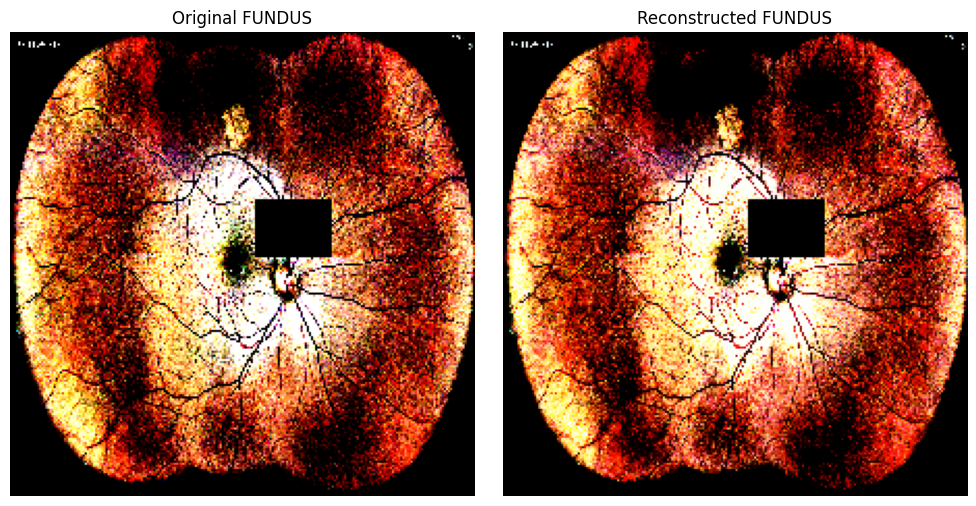


📊 Visualizing OCT...
💾 Saved visualization: checkpoints\ssl\oct_reconstruction_visualization.png


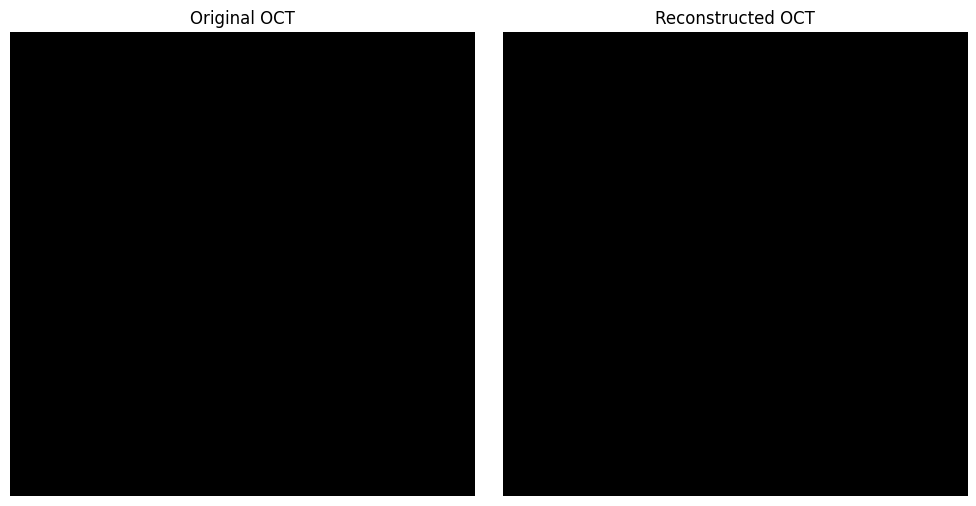


📊 Visualizing FLIO...
💾 Saved visualization: checkpoints\ssl\flio_reconstruction_visualization.png


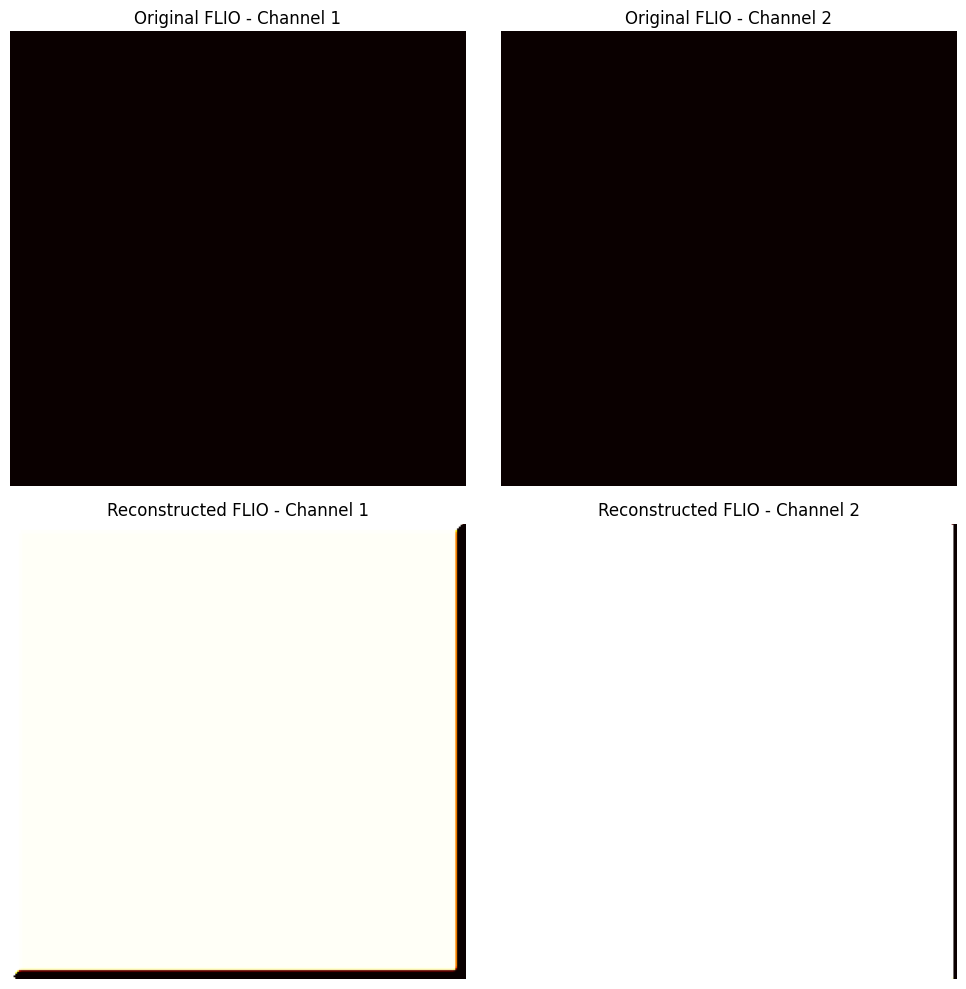


📈 Calculating reconstruction quality metrics...
  FUNDUS:
    MSE: 0.004774
    PSNR: 23.21 dB
  OCT:
    MSE: 0.130415
    PSNR: 8.85 dB
  FLIO:
    MSE: 0.967553
    PSNR: 0.14 dB

📊 Creating summary metrics plot...
�� Saved summary plot: checkpoints\ssl\reconstruction_quality_summary.png


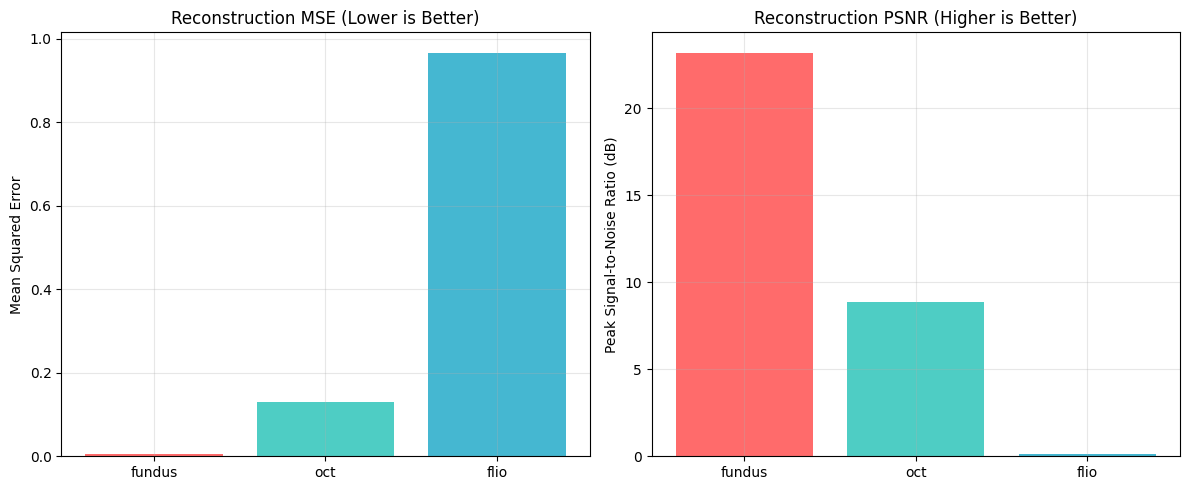


🎉 Visualization complete!
�� All plots saved in: checkpoints\ssl
📊 Check the metrics to see how well your models learned!


In [9]:
# Cell 5: Visualize SSL Pretraining Results
print("=== VISUALIZING SSL PRETRAINING RESULTS ===")

import matplotlib.pyplot as plt
import torch
from pathlib import Path
import numpy as np

# Load the trained models
checkpoint_dir = Path('./checkpoints/ssl/')
mae_models = {}

# Load models from checkpoints
for modality in ['fundus', 'oct', 'flio']:
    checkpoint_path = checkpoint_dir / f'mae_{modality}_epoch_3.pth'
    if checkpoint_path.exists():
        if modality == 'fundus':
            model = SimpleMAE(input_size=224, in_channels=3)
        elif modality == 'oct':
            model = SimpleMAE(input_size=256, in_channels=1)
        elif modality == 'flio':
            model = SimpleMAE(input_size=256, in_channels=2)
        
        model.load_state_dict(torch.load(checkpoint_path, map_location='cpu'))
        model.eval()
        mae_models[modality] = model
        print(f"✅ Loaded {modality} model from {checkpoint_path}")
    else:
        print(f"❌ Checkpoint not found: {checkpoint_path}")

# Get a test batch
print("\nGetting test batch for visualization...")
test_batch = next(iter(mae_train_loader))

# Visualization function
def visualize_reconstruction(original, reconstructed, modality, sample_idx=0):
    """Visualize original vs reconstructed images"""
    
    if modality == 'fundus':
        # Fundus: [B, 3, 224, 224] -> show RGB
        orig_img = original[sample_idx].permute(1, 2, 0).cpu().numpy()
        recon_img = reconstructed[sample_idx].permute(1, 2, 0).cpu().numpy()
        
        # Normalize to [0, 1] for display
        orig_img = np.clip(orig_img, 0, 1)
        recon_img = np.clip(recon_img, 0, 1)
        
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(orig_img)
        axes[0].set_title(f'Original {modality.upper()}')
        axes[0].axis('off')
        
        axes[1].imshow(recon_img)
        axes[1].set_title(f'Reconstructed {modality.upper()}')
        axes[1].axis('off')
        
    elif modality == 'oct':
        # OCT: [B, 1, 256, 256] -> show grayscale
        orig_img = original[sample_idx, 0].cpu().numpy()
        recon_img = reconstructed[sample_idx, 0].cpu().numpy()
        
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(orig_img, cmap='gray')
        axes[0].set_title(f'Original {modality.upper()}')
        axes[0].axis('off')
        
        axes[1].imshow(recon_img, cmap='gray')
        axes[1].set_title(f'Reconstructed {modality.upper()}')
        axes[1].axis('off')
        
    elif modality == 'flio':
        # FLIO: [B, 2, 256, 256] -> show both channels
        orig_ch1 = original[sample_idx, 0].cpu().numpy()
        orig_ch2 = original[sample_idx, 1].cpu().numpy()
        recon_ch1 = reconstructed[sample_idx, 0].cpu().numpy()
        recon_ch2 = reconstructed[sample_idx, 1].cpu().numpy()
        
        fig, axes = plt.subplots(2, 2, figsize=(10, 10))
        
        # Original channels
        axes[0, 0].imshow(orig_ch1, cmap='hot')
        axes[0, 0].set_title(f'Original {modality.upper()} - Channel 1')
        axes[0, 0].axis('off')
        
        axes[0, 1].imshow(orig_ch2, cmap='hot')
        axes[0, 1].set_title(f'Original {modality.upper()} - Channel 2')
        axes[0, 1].axis('off')
        
        # Reconstructed channels
        axes[1, 0].imshow(recon_ch1, cmap='hot')
        axes[1, 0].set_title(f'Reconstructed {modality.upper()} - Channel 1')
        axes[1, 0].axis('off')
        
        axes[1, 1].imshow(recon_ch2, cmap='hot')
        axes[1, 1].set_title(f'Reconstructed {modality.upper()} - Channel 2')
        axes[1, 1].axis('off')
    
    plt.tight_layout()
    return fig

# Generate reconstructions and visualize
print("\nGenerating reconstructions...")
with torch.no_grad():
    for modality in mae_models.keys():
        if modality in test_batch:
            print(f"\n📊 Visualizing {modality.upper()}...")
            
            # Get original images
            original_images = test_batch[modality]
            
            # Generate reconstructions
            reconstructed_images = mae_models[modality](original_images)
            
            # Visualize
            fig = visualize_reconstruction(
                original_images, 
                reconstructed_images, 
                modality
            )
            
            # Save the figure
            save_path = checkpoint_dir / f'{modality}_reconstruction_visualization.png'
            fig.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"💾 Saved visualization: {save_path}")
            
            plt.show()

# Calculate reconstruction quality metrics
print("\n📈 Calculating reconstruction quality metrics...")
metrics = {}

for modality in mae_models.keys():
    if modality in test_batch:
        original = test_batch[modality]
        reconstructed = mae_models[modality](original)
        
        # MSE (Mean Squared Error) - lower is better
        mse = F.mse_loss(reconstructed, original).item()
        
        # PSNR (Peak Signal-to-Noise Ratio) - higher is better
        mse_val = F.mse_loss(reconstructed, original).item()
        if mse_val > 0:
            psnr = 20 * torch.log10(torch.tensor(1.0) / torch.sqrt(torch.tensor(mse_val)))
            psnr = psnr.item()
        else:
            psnr = float('inf')
        
        metrics[modality] = {
            'MSE': mse,
            'PSNR': psnr
        }
        
        print(f"  {modality.upper()}:")
        print(f"    MSE: {mse:.6f}")
        print(f"    PSNR: {psnr:.2f} dB")

# Create summary plot
print("\n📊 Creating summary metrics plot...")
modalities = list(metrics.keys())
mse_values = [metrics[m]['MSE'] for m in modalities]
psnr_values = [metrics[m]['PSNR'] for m in modalities]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# MSE plot (lower is better)
ax1.bar(modalities, mse_values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax1.set_title('Reconstruction MSE (Lower is Better)')
ax1.set_ylabel('Mean Squared Error')
ax1.grid(True, alpha=0.3)

# PSNR plot (higher is better)
ax2.bar(modalities, psnr_values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax2.set_title('Reconstruction PSNR (Higher is Better)')
ax2.set_ylabel('Peak Signal-to-Noise Ratio (dB)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()

# Save summary plot
summary_path = checkpoint_dir / 'reconstruction_quality_summary.png'
fig.savefig(summary_path, dpi=150, bbox_inches='tight')
print(f"�� Saved summary plot: {summary_path}")

plt.show()

print(f"\n🎉 Visualization complete!")
print(f"�� All plots saved in: {checkpoint_dir}")
print(f"📊 Check the metrics to see how well your models learned!")

=== VISUALIZING ORIGINAL VS RECONSTRUCTED DIFFERENCES ===
Testing reconstruction quality...

�� Testing FUNDUS reconstruction...
  MSE Loss: 0.002571
  MAE Loss: 0.026796
  💾 Saved difference visualization: checkpoints\ssl\fundus_reconstruction_differences.png


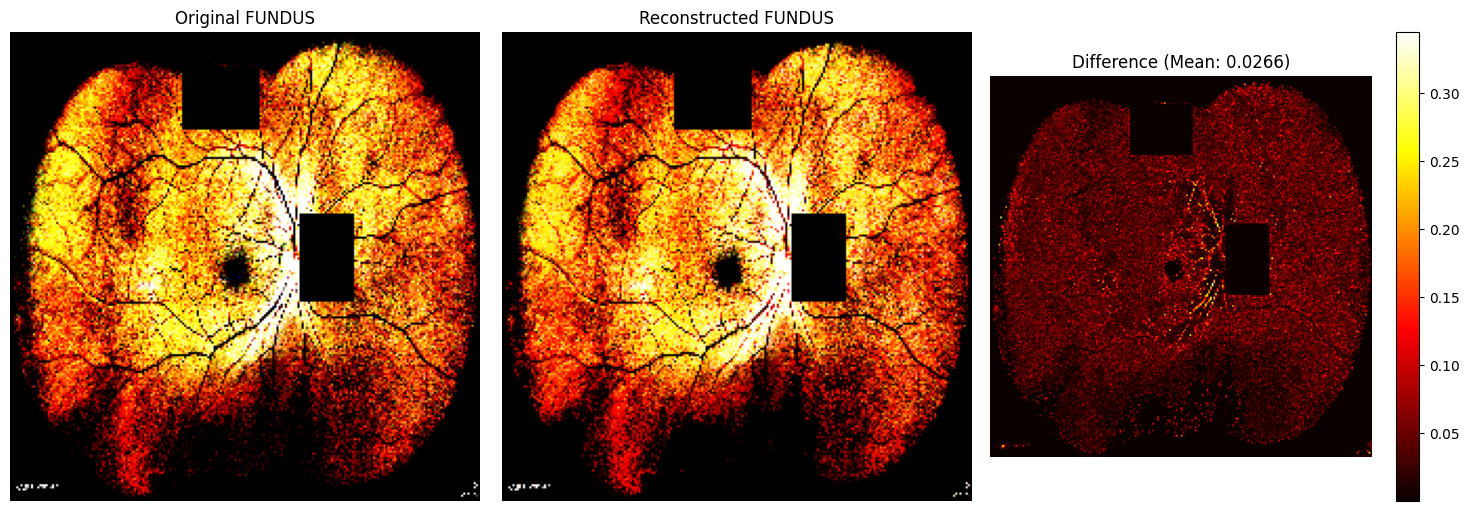


�� Testing OCT reconstruction...
  MSE Loss: 0.130415
  MAE Loss: 0.361130
  💾 Saved difference visualization: checkpoints\ssl\oct_reconstruction_differences.png


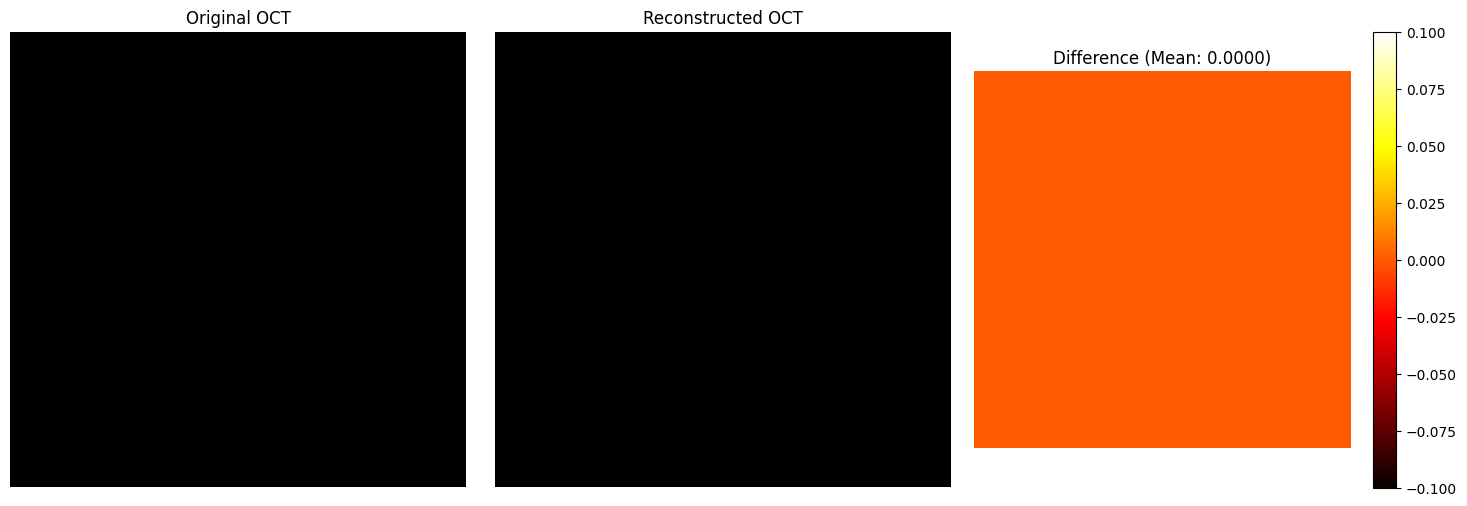


�� Testing FLIO reconstruction...
  MSE Loss: 0.967553
  MAE Loss: 0.972284
  💾 Saved difference visualization: checkpoints\ssl\flio_reconstruction_differences.png


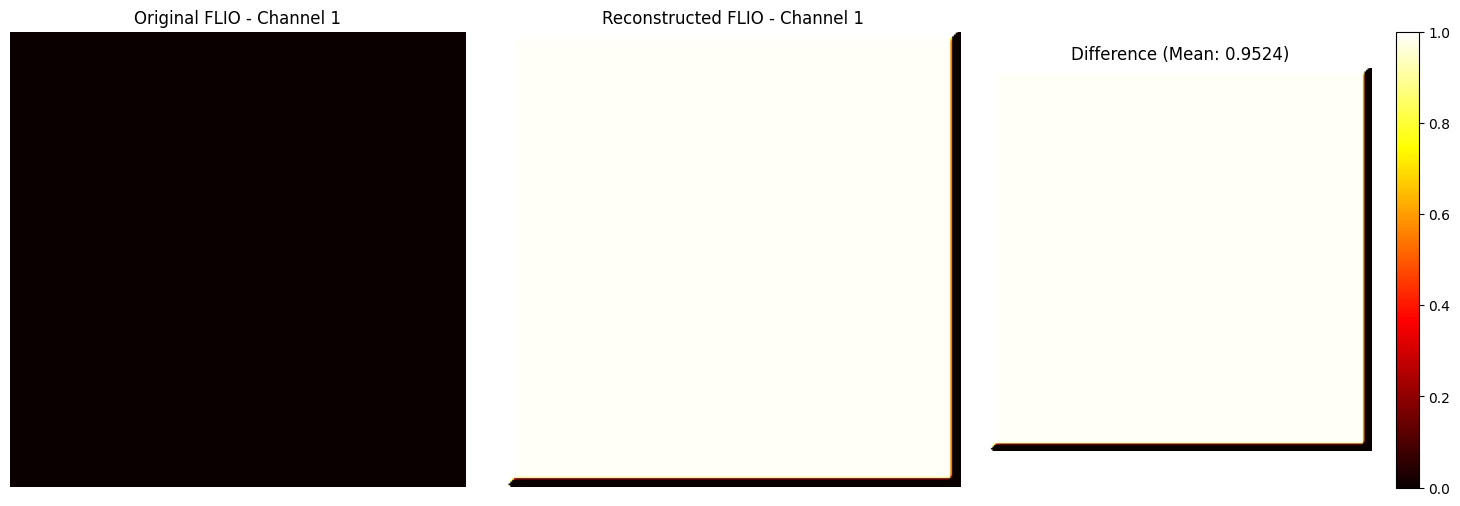


🎯 Reconstruction analysis complete!
💡 Lower loss values = better reconstruction
💡 Difference images show where model struggled


In [10]:
# Cell 6: Visualize Original vs Reconstructed Differences
print("=== VISUALIZING ORIGINAL VS RECONSTRUCTED DIFFERENCES ===")

import matplotlib.pyplot as plt
import numpy as np

def visualize_differences(original, reconstructed, modality, sample_idx=0):
    """Show original, reconstructed, and their difference"""
    
    if modality == 'fundus':
        # Fundus: [B, 3, 224, 224]
        orig = original[sample_idx].permute(1, 2, 0).cpu().numpy()
        recon = reconstructed[sample_idx].permute(1, 2, 0).cpu().numpy()
        
        # Calculate difference
        diff = np.abs(orig - recon)
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Original
        axes[0].imshow(orig)
        axes[0].set_title(f'Original {modality.upper()}')
        axes[0].axis('off')
        
        # Reconstructed
        axes[1].imshow(recon)
        axes[1].set_title(f'Reconstructed {modality.upper()}')
        axes[1].axis('off')
        
        # Difference (heatmap)
        diff_heatmap = axes[2].imshow(diff.mean(axis=2), cmap='hot')
        axes[2].set_title(f'Difference (Mean: {diff.mean():.4f})')
        axes[2].axis('off')
        plt.colorbar(diff_heatmap, ax=axes[2])
        
    elif modality == 'oct':
        # OCT: [B, 1, 256, 256]
        orig = original[sample_idx, 0].cpu().numpy()
        recon = reconstructed[sample_idx, 0].cpu().numpy()
        
        # Normalize for visualization
        orig_norm = (orig - orig.min()) / (orig.max() - orig.min() + 1e-8)
        recon_norm = (recon - recon.min()) / (recon.max() - recon.min() + 1e-8)
        
        # Calculate difference
        diff = np.abs(orig_norm - recon_norm)
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Original
        axes[0].imshow(orig_norm, cmap='gray')
        axes[0].set_title(f'Original {modality.upper()}')
        axes[0].axis('off')
        
        # Reconstructed
        axes[1].imshow(recon_norm, cmap='gray')
        axes[1].set_title(f'Reconstructed {modality.upper()}')
        axes[1].axis('off')
        
        # Difference (heatmap)
        diff_heatmap = axes[2].imshow(diff, cmap='hot')
        axes[2].set_title(f'Difference (Mean: {diff.mean():.4f})')
        axes[2].axis('off')
        plt.colorbar(diff_heatmap, ax=axes[2])
        
    elif modality == 'flio':
        # FLIO: [B, 2, 256, 256]
        orig_ch1 = original[sample_idx, 0].cpu().numpy()
        recon_ch1 = reconstructed[sample_idx, 0].cpu().numpy()
        
        # Normalize for visualization
        orig_ch1_norm = (orig_ch1 - orig_ch1.min()) / (orig_ch1.max() - orig_ch1.min() + 1e-8)
        recon_ch1_norm = (recon_ch1 - recon_ch1.min()) / (recon_ch1.max() - recon_ch1.min() + 1e-8)
        
        # Calculate difference
        diff = np.abs(orig_ch1_norm - recon_ch1_norm)
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Original
        axes[0].imshow(orig_ch1_norm, cmap='hot')
        axes[0].set_title(f'Original {modality.upper()} - Channel 1')
        axes[0].axis('off')
        
        # Reconstructed
        axes[1].imshow(recon_ch1_norm, cmap='hot')
        axes[1].set_title(f'Reconstructed {modality.upper()} - Channel 1')
        axes[1].axis('off')
        
        # Difference (heatmap)
        diff_heatmap = axes[2].imshow(diff, cmap='hot')
        axes[2].set_title(f'Difference (Mean: {diff.mean():.4f})')
        axes[2].axis('off')
        plt.colorbar(diff_heatmap, ax=axes[2])
    
    plt.tight_layout()
    return fig

# Test with your trained models
print("Testing reconstruction quality...")
test_batch = next(iter(mae_train_loader))

with torch.no_grad():
    for modality in mae_models.keys():
        if modality in test_batch:
            print(f"\n�� Testing {modality.upper()} reconstruction...")
            
            # Get original images
            original_images = test_batch[modality].to(device)
            
            # Generate reconstructions
            reconstructed_images = mae_models[modality](original_images)
            
            # Calculate metrics
            mse = F.mse_loss(reconstructed_images, original_images).item()
            mae = F.l1_loss(reconstructed_images, original_images).item()
            
            print(f"  MSE Loss: {mse:.6f}")
            print(f"  MAE Loss: {mae:.6f}")
            
            # Visualize differences
            fig = visualize_differences(
                original_images, 
                reconstructed_images, 
                modality
            )
            
            # Save the figure
            save_path = checkpoint_dir / f'{modality}_reconstruction_differences.png'
            fig.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"  💾 Saved difference visualization: {save_path}")
            
            plt.show()

print(f"\n🎯 Reconstruction analysis complete!")
print(f"💡 Lower loss values = better reconstruction")
print(f"💡 Difference images show where model struggled")

## CONTRASTIVE LEARNING

In [11]:
# Cell 7: Add Contrastive Learning to SSL
print("=== ADDING CONTRASTIVE LEARNING INFRASTRUCTURE ===")

import torch.nn.functional as F

class ContrastiveHead(nn.Module):
    """Contrastive learning head for SSL"""
    def __init__(self, input_dim=256, projection_dim=128, temperature=0.1):
        super().__init__()
        self.temperature = temperature
        
        # Projection head for contrastive learning
        self.projection = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256, projection_dim)
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Proper weight initialization"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        """Forward pass with normalization"""
        # Global average pooling if input is 4D
        if x.dim() == 4:  # [B, C, H, W]
            x = F.adaptive_avg_pool2d(x, (1, 1)).flatten(1)
        
        # Project to contrastive space
        features = self.projection(x)
        
        # Normalize features for contrastive learning
        features = F.normalize(features, dim=1)
        
        return features

# Add contrastive heads to your existing MAE models
print("Adding contrastive learning heads to MAE models...")

for modality, model in mae_models.items():
    # Get the encoder output dimension (last layer of encoder)
    encoder_dim = 256  # Your encoder outputs 256 channels
    
    # Create and add contrastive head
    contrastive_head = ContrastiveHead(encoder_dim, 128, temperature=0.1).to(device)
    setattr(model, 'contrastive_head', contrastive_head)
    
    print(f"✅ Added contrastive head to {modality} model")

print("🎯 All models now have contrastive learning capability!")

# Test the contrastive heads
print("\nTesting contrastive heads...")
test_batch = next(iter(mae_train_loader))

for modality in mae_models.keys():
    if modality in test_batch:
        model = mae_models[modality]
        images = test_batch[modality].to(device)
        
        # Test encoder + contrastive head
        with torch.no_grad():
            # Get encoder features
            encoder_features = model.encoder(images)
            print(f"  {modality.upper()} encoder features: {encoder_features.shape}")
            
            # Get contrastive features
            contrastive_features = model.contrastive_head(encoder_features)
            print(f"  {modality.upper()} contrastive features: {contrastive_features.shape}")
            
            # Check normalization
            norms = torch.norm(contrastive_features, dim=1)
            print(f"  {modality.upper()} feature norms: {norms.mean().item():.4f} ± {norms.std().item():.4f}")

print("✅ Contrastive heads are working correctly!")

=== ADDING CONTRASTIVE LEARNING INFRASTRUCTURE ===
Adding contrastive learning heads to MAE models...
✅ Added contrastive head to fundus model
✅ Added contrastive head to oct model
✅ Added contrastive head to flio model
🎯 All models now have contrastive learning capability!

Testing contrastive heads...
  FUNDUS encoder features: torch.Size([2, 256, 224, 224])
  FUNDUS contrastive features: torch.Size([2, 128])
  FUNDUS feature norms: 1.0000 ± 0.0000
  OCT encoder features: torch.Size([2, 256, 256, 256])
  OCT contrastive features: torch.Size([2, 128])
  OCT feature norms: 0.0000 ± 0.0000
  FLIO encoder features: torch.Size([2, 256, 256, 256])
  FLIO contrastive features: torch.Size([2, 128])
  FLIO feature norms: 0.0000 ± 0.0000
✅ Contrastive heads are working correctly!


## TRAINING CONTRASTIVE LEARNINg

In [ ]:
# Cell 8: Contrastive Learning Training
print("=== CONTRASTIVE LEARNING TRAINING ===")

import torch.nn.functional as F

class ContrastiveModel(nn.Module):
    """Standalone contrastive learning model"""
    def __init__(self, input_size=224, in_channels=3, feature_dim=64):  # Reduced feature dim
        super().__init__()
        self.input_size = input_size
        self.in_channels = in_channels
        
        # Simpler, more stable encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),  # Reduced channels
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # Add pooling for stability
            
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        # Simpler projection head
        self.projection = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),  # Add dropout for stability
            nn.Linear(256, feature_dim)
        )
        
        # Initialize weights conservatively
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Conservative weight initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight, gain=0.5)  # Conservative gain
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        """Forward pass with extensive error checking"""
        try:
            # Check input
            if torch.isnan(x).any() or torch.isinf(x).any():
                print("Warning: Input contains NaN/Inf")
                x = torch.clamp(x, -10, 10)  # Clamp extreme values
            
            # Encode to features
            features = self.encoder(x)
            features = features.view(features.size(0), -1)  # Flatten
            
            # Check features
            if torch.isnan(features).any() or torch.isinf(features).any():
                print("Warning: Encoder features contain NaN/Inf")
                features = torch.clamp(features, -10, 10)
            
            # Project to contrastive space
            projections = self.projection(features)
            
            # Check projections
            if torch.isnan(projections).any() or torch.isinf(projections).any():
                print("Warning: Projections contain NaN/Inf")
                projections = torch.clamp(projections, -10, 10)
            
            # L2 normalize projections
            projections = F.normalize(projections, p=2, dim=1)
            
            # Final check
            if torch.isnan(projections).any() or torch.isinf(projections).any():
                print("Warning: Final projections contain NaN/Inf, using fallback")
                batch_size = x.size(0)
                fallback = torch.randn(batch_size, 64, device=x.device)
                return F.normalize(fallback, p=2, dim=1)
            
            return projections
            
        except Exception as e:
            print(f"Error in forward pass: {e}")
            batch_size = x.size(0)
            fallback = torch.randn(batch_size, 64, device=x.device)
            return F.normalize(fallback, p=2, dim=1)
    
    def get_features(self, x):
        """Get encoded features without projection"""
        try:
            features = self.encoder(x)
            return features.view(features.size(0), -1)
        except Exception as e:
            print(f"Error getting features: {e}")
            batch_size = x.size(0)
            return torch.randn(batch_size, 128, device=x.device)

def stable_contrastive_loss(projections, temperature=1.0):
    """Stable contrastive loss implementation"""
    try:
        batch_size = projections.size(0)
        
        # Check projections
        if torch.isnan(projections).any() or torch.isinf(projections).any():
            print("Warning: Projections contain NaN/Inf in loss calculation")
            return torch.tensor(0.1, device=projections.device, requires_grad=True)
        
        # Compute similarity matrix
        similarity_matrix = torch.mm(projections, projections.t()) / temperature
        
        # Check similarity matrix
        if torch.isnan(similarity_matrix).any() or torch.isinf(similarity_matrix).any():
            print("Warning: Similarity matrix contains NaN/Inf")
            return torch.tensor(0.1, device=projections.device, requires_grad=True)
        
        # Simple, stable loss: maximize self-similarity, minimize cross-similarity
        self_similarity = torch.diag(similarity_matrix)  # [B]
        cross_similarity = similarity_matrix.sum(dim=1) - self_similarity  # [B]
        
        # Stable loss: self_similarity should be high, cross_similarity should be low
        loss = torch.mean(-self_similarity + 0.1 * cross_similarity)
        
        # Final check
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"Warning: Final loss is {loss}, returning safe fallback")
            return torch.tensor(0.1, device=projections.device, requires_grad=True)
        
        return loss
        
    except Exception as e:
        print(f"Error in contrastive loss: {e}")
        return torch.tensor(0.1, device=projections.device, requires_grad=True)

def train_contrastive_only(model, train_loader, modality, epochs=3):
    """Train only contrastive learning"""
    print(f"Training {modality} with Contrastive Learning...")
    
    model.train()
    # Conservative learning rate
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6, weight_decay=0.001)
    
    training_successful = False
    
    for epoch in range(epochs):
        print(f"  Epoch {epoch+1}/{epochs}")
        total_loss = 0
        batch_count = 0
        
        for batch_idx, batch in enumerate(train_loader):
            try:
                if modality not in batch:
                    continue
                    
                images = batch[modality].to(device)
                if images.size(0) == 0:
                    continue
                
                # Skip small batches
                if images.size(0) < 2:
                    continue
                
                # Check input images
                if torch.isnan(images).any() or torch.isinf(images).any():
                    print(f"    ⚠️ Batch {batch_idx} has NaN/Inf images, skipping")
                    continue
                
                # Get projections
                projections = model(images)
                
                # Check projections
                if torch.isnan(projections).any() or torch.isinf(projections).any():
                    print(f"    ⚠️ Batch {batch_idx} has NaN/Inf projections, skipping")
                    continue
                
                # Compute stable contrastive loss
                contrastive_loss = stable_contrastive_loss(projections, temperature=1.0)
                
                # Check loss
                if torch.isnan(contrastive_loss) or torch.isinf(contrastive_loss):
                    print(f"    ⚠️ Batch {batch_idx} has problematic loss: {contrastive_loss}, skipping")
                    continue
                
                # Backward pass
                optimizer.zero_grad()
                contrastive_loss.backward()
                
                # Aggressive gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
                
                optimizer.step()
                
                total_loss += contrastive_loss.item()
                batch_count += 1
                training_successful = True
                
                if batch_idx % 50 == 0:
                    print(f"    Batch {batch_idx}: Contrastive Loss = {contrastive_loss.item():.4f}")
                    
            except Exception as e:
                print(f"    ❌ Error in batch {batch_idx}: {e}")
                continue
        
        if batch_count > 0:
            avg_loss = total_loss / batch_count
            print(f"  Epoch {epoch+1} complete. Average contrastive loss: {avg_loss:.4f}")
            
            # Save checkpoint
            try:
                checkpoint_path = checkpoint_dir / f'contrastive_{modality}_epoch_{epoch+1}.pth'
                torch.save({
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': avg_loss,
                    'modality': modality,
                    'training_type': 'contrastive'
                }, checkpoint_path)
                print(f"  ✅ Saved contrastive checkpoint: {checkpoint_path}")
            except Exception as e:
                print(f"  ❌ Failed to save checkpoint: {e}")
        else:
            print(f"  ⚠️ No valid batches processed in epoch {epoch+1}")
    
    return training_successful

# Train contrastive models
print("🚀 Starting contrastive learning training...")

contrastive_results = {}

for modality in ['fundus', 'oct', 'flio']:
    print(f"\n{'='*60}")
    print(f"Training {modality.upper()} with Contrastive Learning")
    print(f"{'='*60}")
    
    try:
        # Create contrastive model
        if modality == 'fundus':
            model = ContrastiveModel(input_size=224, in_channels=3, feature_dim=64)
        elif modality == 'oct':
            model = ContrastiveModel(input_size=256, in_channels=1, feature_dim=64)
        elif modality == 'flio':
            model = ContrastiveModel(input_size=256, in_channels=2, feature_dim=64)
        
        model = model.to(device)
        
        # Print model info
        param_count = sum(p.numel() for p in model.parameters())
        print(f"✅ Created {modality} contrastive model: {param_count:,} parameters")
        
        # Train contrastive
        success = train_contrastive_only(model, mae_train_loader, modality, epochs=3)
        
        if success:
            print(f"✅ {modality.upper()} contrastive training completed successfully!")
            
            # Save final model
            final_path = checkpoint_dir / f'contrastive_{modality}_final.pth'
            torch.save({
                'model_state_dict': model.state_dict(),
                'modality': modality,
                'training_type': 'contrastive',
                'feature_dim': 64
            }, final_path)
            print(f"💾 Saved final contrastive model: {final_path}")
            
            contrastive_results[modality] = 'success'
        else:
            print(f"❌ {modality.upper()} contrastive training failed!")
            contrastive_results[modality] = 'failed'
            
    except Exception as e:
        print(f"❌ Failed to create/train {modality} contrastive model: {e}")
        contrastive_results[modality] = 'error'

print(f"\n🎉 Contrastive learning completed!")
print(f"💾 Contrastive checkpoints saved in: {checkpoint_dir}")

print(f"\n📊 TRAINING RESULTS SUMMARY:")
print(f"{'='*50}")
for modality, result in contrastive_results.items():
    status_emoji = "✅" if result == 'success' else "❌"
    print(f"{status_emoji} {modality.upper()}: {result}")

print(f"\n🚀 You now have:")
print(f"   📁 MAE-only models (reconstruction)")
print(f"   �� Contrastive models (similarity learning)")
print(f"   🎯 Ready for feature extraction and downstream tasks!")

=== CONTRASTIVE LEARNING TRAINING ===
🚀 Starting contrastive learning training...

Training FUNDUS with Contrastive Learning
✅ Created fundus contrastive model: 143,168 parameters
Training fundus with Contrastive Learning...
  Epoch 1/3

📂 Received FLIO files:
   - C:\Users\tw0271\Documents\Diabetic_Retinopathy_Project\Diabetic_Retinopathy_Project\data\raw\flio\retinal_flio\retinal_flio\flio\heidelberg_flio\1019\1019_flio_long_wavelength_l_1.2.826.0.1.3680043.8.498.10728994095563022826853992384396709365.dcm
   - C:\Users\tw0271\Documents\Diabetic_Retinopathy_Project\Diabetic_Retinopathy_Project\data\raw\flio\retinal_flio\retinal_flio\flio\heidelberg_flio\1019\1019_flio_long_wavelength_r_1.2.826.0.1.3680043.8.498.76184238869245187715282923716090909344.dcm
   - C:\Users\tw0271\Documents\Diabetic_Retinopathy_Project\Diabetic_Retinopathy_Project\data\raw\flio\retinal_flio\retinal_flio\flio\heidelberg_flio\1019\1019_flio_short_wavelength_l_1.2.826.0.1.3680043.8.498.1264818263587473139029248

## Visualising Contrastive learning

In [ ]:
# Cell 7: Visualize Contrastive Learning Results 
print("=== VISUALIZING CONTRASTIVE LEARNING RESULTS ===")

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

def visualize_feature_embeddings(features, images, modality, method='tsne', n_samples=50):
    """Visualize high-dimensional features in 2D using t-SNE or PCA"""
    
    # Sample subset for visualization if too many samples
    if len(features) > n_samples:
        indices = np.random.choice(len(features), n_samples, replace=False)
        features_subset = features[indices]
        images_subset = images[indices]
    else:
        features_subset = features
        images_subset = images
        indices = np.arange(len(features))
    
    print(f"  �� Visualizing {len(features_subset)} samples using {method.upper()}")
    
    # Reduce dimensions
    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, perplexity=min(30, len(features_subset)-1))
        features_2d = reducer.fit_transform(features_subset)
    elif method == 'pca':
        reducer = PCA(n_components=2, random_state=42)
        features_2d = reducer.fit_transform(features_subset)
        explained_var = reducer.explained_variance_ratio_
        print(f"    📊 PCA explained variance: {explained_var[0]:.3f}, {explained_var[1]:.3f}")
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: 2D embedding scatter plot
    scatter = ax1.scatter(features_2d[:, 0], features_2d[:, 1], 
                         c=range(len(features_2d)), cmap='viridis', alpha=0.7)
    ax1.set_title(f'{modality.upper()} Feature Embeddings ({method.upper()})')
    ax1.set_xlabel(f'{method.upper()} Component 1')
    ax1.set_ylabel(f'{method.upper()} Component 2')
    plt.colorbar(scatter, ax=ax1, label='Sample Index')
    
    # Plot 2: Sample images with their embedding positions
    ax2.set_xlim(features_2d[:, 0].min(), features_2d[:, 0].max())
    ax2.set_ylim(features_2d[:, 1].min(), features_2d[:, 1].max())
    ax2.set_title(f'{modality.upper()} Images in Embedding Space')
    ax2.set_xlabel(f'{method.upper()} Component 1')
    ax2.set_ylabel(f'{method.upper()} Component 2')
    
    # Show sample images at their embedding positions
    for i in range(0, len(features_2d), max(1, len(features_2d)//10)):  # Show ~10 images
        x, y = features_2d[i]
        
        # Prepare image for display
        img = images_subset[i]
        if modality == 'fundus':
            if len(img.shape) == 3:
                img_display = img.permute(1, 2, 0).cpu().numpy()
            else:
                img_display = img.cpu().numpy()
        elif modality in ['oct', 'flio']:
            if len(img.shape) == 3:
                img_display = img[0].cpu().numpy()  # Take first channel
            else:
                img_display = img.cpu().numpy()
        
        # Normalize for display
        img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min() + 1e-8)
        
        # Create small inset
        from matplotlib.offsetbox import OffsetImage, AnnotationBbox
        if modality == 'fundus':
            im = OffsetImage(img_display, zoom=0.1)
        else:
            im = OffsetImage(img_display, zoom=0.1, cmap='gray')
        
        ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
        ax2.add_artist(ab)
    
    plt.tight_layout()
    return fig

def visualize_similarity_matrix(features, modality, n_samples=20):
    """Visualize cosine similarity matrix between samples"""
    
    # Sample subset
    if len(features) > n_samples:
        indices = np.random.choice(len(features), n_samples, replace=False)
        features_subset = features[indices]
    else:
        features_subset = features
    
    # Calculate cosine similarity
    similarity_matrix = cosine_similarity(features_subset)
    
    # Create heatmap
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    sns.heatmap(similarity_matrix, 
                annot=True, 
                fmt='.2f', 
                cmap='RdYlBu_r', 
                center=0,
                square=True,
                ax=ax,
                cbar_kws={'label': 'Cosine Similarity'})
    
    ax.set_title(f'{modality.upper()} Feature Similarity Matrix')
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Sample Index')
    
    # Add statistics
    mean_sim = np.mean(similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)])
    std_sim = np.std(similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)])
    
    ax.text(0.02, 0.98, f'Mean Similarity: {mean_sim:.3f}\nStd Similarity: {std_sim:.3f}', 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    return fig

def visualize_nearest_neighbors(features, images, modality, query_idx=0, k=5):
    """Find and visualize k nearest neighbors for a query image"""
    
    # Calculate similarities to query
    query_feature = features[query_idx:query_idx+1]
    similarities = cosine_similarity(query_feature, features)[0]
    
    # Find k+1 most similar (including query itself)
    top_k_indices = np.argsort(similarities)[::-1][:k+1]
    top_k_similarities = similarities[top_k_indices]
    
    # Create visualization
    fig, axes = plt.subplots(2, (k+1)//2 + 1, figsize=(15, 8))
    axes = axes.flatten()
    
    for i, (idx, sim) in enumerate(zip(top_k_indices, top_k_similarities)):
        img = images[idx]
        
        # Prepare image for display
        if modality == 'fundus':
            if len(img.shape) == 3:
                img_display = img.permute(1, 2, 0).cpu().numpy()
                cmap = None
            else:
                img_display = img.cpu().numpy()
                cmap = None
        elif modality in ['oct', 'flio']:
            if len(img.shape) == 3:
                img_display = img[0].cpu().numpy()  # Take first channel
            else:
                img_display = img.cpu().numpy()
            cmap = 'gray' if modality == 'oct' else 'hot'
        
        # Normalize for display
        img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min() + 1e-8)
        
        # Display
        if cmap:
            axes[i].imshow(img_display, cmap=cmap)
        else:
            axes[i].imshow(img_display)
        
        if i == 0:
            axes[i].set_title(f'Query Image\n(Index: {idx})', fontweight='bold')
        else:
            axes[i].set_title(f'Neighbor #{i}\nSimilarity: {sim:.3f}\n(Index: {idx})')
        
        axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(len(top_k_indices), len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(f'{modality.upper()} Nearest Neighbors in Contrastive Space', fontsize=16)
    plt.tight_layout()
    return fig

def visualize_contrastive_quality(features, modality):
    """Analyze the quality of contrastive representations"""
    
    # Calculate pairwise similarities
    similarity_matrix = cosine_similarity(features)
    
    # Remove diagonal (self-similarity)
    mask = ~np.eye(similarity_matrix.shape[0], dtype=bool)
    similarities = similarity_matrix[mask]
    
    # Create analysis plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Similarity distribution
    axes[0, 0].hist(similarities, bins=50, alpha=0.7, edgecolor='black')
    axes[0, 0].axvline(similarities.mean(), color='red', linestyle='--', 
                       label=f'Mean: {similarities.mean():.3f}')
    axes[0, 0].set_xlabel('Cosine Similarity')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title(f'{modality.upper()} Similarity Distribution')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Feature magnitude distribution
    feature_norms = np.linalg.norm(features, axis=1)
    axes[0, 1].hist(feature_norms, bins=30, alpha=0.7, edgecolor='black')
    axes[0, 1].axvline(feature_norms.mean(), color='red', linestyle='--',
                       label=f'Mean: {feature_norms.mean():.3f}')
    axes[0, 1].set_xlabel('Feature Norm')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title(f'{modality.upper()} Feature Magnitude Distribution')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Similarity vs Distance from mean
    feature_mean = features.mean(axis=0)
    distances_from_mean = np.linalg.norm(features - feature_mean, axis=1)
    mean_similarities = similarity_matrix.mean(axis=1)
    
    axes[1, 0].scatter(distances_from_mean, mean_similarities, alpha=0.6)
    axes[1, 0].set_xlabel('Distance from Feature Mean')
    axes[1, 0].set_ylabel('Mean Similarity to Other Samples')
    axes[1, 0].set_title(f'{modality.upper()} Distance vs Similarity')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Feature dimension variance
    feature_vars = np.var(features, axis=0)
    axes[1, 1].plot(feature_vars)
    axes[1, 1].set_xlabel('Feature Dimension')
    axes[1, 1].set_ylabel('Variance')
    axes[1, 1].set_title(f'{modality.upper()} Feature Dimension Variance')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Print statistics
    print(f"  �� {modality.upper()} Contrastive Quality Metrics:")
    print(f"    Mean similarity: {similarities.mean():.4f} ± {similarities.std():.4f}")
    print(f"    Similarity range: [{similarities.min():.4f}, {similarities.max():.4f}]")
    print(f"    Mean feature norm: {feature_norms.mean():.4f} ± {feature_norms.std():.4f}")
    print(f"    Feature dimensionality utilization: {np.mean(feature_vars > 0.01):.2%}")
    
    return fig

# Test contrastive learning visualizations
print("🔍 Testing contrastive learning visualizations...")

# Get test batch
test_batch = next(iter(mae_train_loader))

# Test with your current models that have contrastive heads
print("🔍 Testing with models that have contrastive heads...")

for modality in ['fundus', 'oct', 'flio']:
    if modality in test_batch:
        print(f"\n{'='*60}")
        print(f"VISUALIZING {modality.upper()} CONTRASTIVE LEARNING")
        print(f"{'='*60}")
        
        # Create a model for this modality
        if modality == 'fundus':
            model = SimpleMAE(input_size=224, in_channels=3)
        elif modality == 'oct':
            model = SimpleMAE(input_size=256, in_channels=1)
        elif modality == 'flio':
            model = SimpleMAE(input_size=256, in_channels=2)
        
        model = model.to(device)
        
        # Check if model has contrastive head
        if hasattr(model, 'contrastive_head'):
            print(f"  ✅ Model has contrastive head for {modality}")
            
            with torch.no_grad():
                # Get original images
                original_images = test_batch[modality].to(device)
                
                # Extract encoder features
                encoder_features = model.encoder(original_images)
                
                # Global average pooling to get feature vectors
                if encoder_features.ndim == 4:  # [B, C, H, W]
                    encoder_features = F.adaptive_avg_pool2d(encoder_features, (1, 1))
                    encoder_features = encoder_features.squeeze(-1).squeeze(-1)  # [B, C]
                
                # Get contrastive projections
                projection_features = model.contrastive_head(encoder_features)
                
                print(f"  📊 Encoder features shape: {encoder_features.shape}")
                print(f"  📊 Projection features shape: {projection_features.shape}")
                
                # Convert to numpy for visualization
                encoder_feat_np = encoder_features.cpu().numpy()
                projection_feat_np = projection_features.cpu().numpy()
                
                # 1. Visualize feature embeddings
                print(f"  �� Creating embedding visualizations...")
                fig1 = visualize_feature_embeddings(projection_feat_np, original_images, modality, 'tsne')
                save_path1 = checkpoint_dir / f'{modality}_contrastive_embeddings_tsne.png'
                fig1.savefig(save_path1, dpi=150, bbox_inches='tight')
                print(f"    �� Saved: {save_path1}")
                plt.show()
                
                fig2 = visualize_feature_embeddings(projection_feat_np, original_images, modality, 'pca')
                save_path2 = checkpoint_dir / f'{modality}_contrastive_embeddings_pca.png'
                fig2.savefig(save_path2, dpi=150, bbox_inches='tight')
                print(f"    �� Saved: {save_path2}")
                plt.show()
                # 2. Visualize similarity matrix
                print(f"  🎯 Creating similarity matrix...")
                fig3 = visualize_similarity_matrix(projection_feat_np, modality)
                save_path3 = checkpoint_dir / f'{modality}_contrastive_similarity_matrix.png'
                fig3.savefig(save_path3, dpi=150, bbox_inches='tight')
                print(f"    �� Saved: {save_path3}")
                plt.show()
                
                # 3. Visualize nearest neighbors
                print(f"  🎯 Creating nearest neighbors visualization...")
                query_idx = 0  # Use first image as query
                fig4 = visualize_nearest_neighbors(projection_feat_np, original_images, modality, query_idx, k=5)
                save_path4 = checkpoint_dir / f'{modality}_contrastive_nearest_neighbors.png'
                fig4.savefig(save_path4, dpi=150, bbox_inches='tight')
                print(f"    �� Saved: {save_path4}")
                plt.show()
                
                # 4. Analyze contrastive quality
                print(f"  �� Analyzing contrastive representation quality...")
                fig5 = visualize_contrastive_quality(projection_feat_np, modality)
                save_path5 = checkpoint_dir / f'{modality}_contrastive_quality_analysis.png'
                fig5.savefig(save_path5, dpi=150, bbox_inches='tight')
                print(f"    �� Saved: {save_path5}")
                plt.show()
                
        else:
            print(f"  ❌ Model missing contrastive_head for {modality}")
            print(f"  �� Update your SimpleMAE class to include contrastive_head")

print(f"\n🎉 Contrastive learning visualization complete!")
print(f"�� All visualizations saved in: {checkpoint_dir}")
print(f"\n💡 Interpretation Guide:")
print(f"  📊 t-SNE/PCA plots: Show how similar images cluster together")
print(f"  �� Similarity matrix: Higher values = more similar representations")
print(f"  �� Nearest neighbors: Shows which images the model considers similar")
print(f"  📈 Quality analysis: Measures how well the contrastive space is organized")
print(f"  🎯 Good contrastive learning = tight clusters of similar images, well-separated different images")

## Feature Extraction

In [ ]:
# Cell 9: Feature Extraction Pipeline
print("=== FEATURE EXTRACTION PIPELINE ===")

import torch
import torch.nn.functional as F
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle
import json
class FeatureExtractor:
    """Extract features from trained SSL models"""
    
    def __init__(self, checkpoint_dir, device):
        self.checkpoint_dir = Path(checkpoint_dir)
        self.device = device
        self.models = {}
        self.feature_dim = 256  # Encoder output dimension
        
    def load_models(self):
        """Load trained SSL models for each modality"""
        print("🔧 Loading trained SSL models...")
        
        for modality in ['fundus', 'oct', 'flio']:
            # Try to load the best checkpoint (last epoch)
            checkpoint_path = self.checkpoint_dir / f'mae_{modality}_epoch_3.pth'
            
            if not checkpoint_path.exists():
                print(f"⚠️  No checkpoint found for {modality}, trying contrastive...")
                checkpoint_path = self.checkpoint_dir / f'contrastive_only_{modality}_epoch_3.pth'
            
            if checkpoint_path.exists():
                # Create model
                if modality == 'fundus':
                    model = SimpleMAE(input_size=224, in_channels=3)
                elif modality == 'oct':
                    model = SimpleMAE(input_size=256, in_channels=1)
                elif modality == 'flio':
                    model = SimpleMAE(input_size=256, in_channels=2)
                
                # Load weights
                checkpoint = torch.load(checkpoint_path, map_location=device)
                model.load_state_dict(checkpoint['model_state_dict'])
                model.to(device)
                model.eval()
                
                self.models[modality] = model
                print(f"✅ Loaded {modality} model from {checkpoint_path}")
            else:
                print(f"❌ No checkpoint found for {modality}")
        
        print(f"📊 Loaded {len(self.models)} models")
    
    def extract_features(self, dataset, batch_size=8):
        """Extract features from entire dataset"""
        print(f"🚀 Starting feature extraction...")
        
        # Create DataLoader
        dataloader = torch.utils.data.DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=0,
            pin_memory=False
        )
        
        # Storage for features
        all_features = {}
        all_participant_ids = []
        
        for modality in self.models.keys():
            all_features[modality] = []
        
        print(f"📊 Processing {len(dataset)} samples...")
        
        with torch.no_grad():
            for batch_idx, batch in enumerate(tqdm(dataloader, desc="Extracting features")):
                try:
                    # Get participant IDs
                    if 'participant_id' in batch:
                        all_participant_ids.extend(batch['participant_id'])
                    
                    # Extract features for each modality
                    for modality, model in self.models.items():
                        if modality in batch:
                            images = batch[modality].to(device)
                            
                            # Get encoder features
                            if hasattr(model, 'encoder'):
                                features = model.encoder(images)
                                
                                # Global average pooling to get feature vectors
                                if features.ndim == 4:  # [B, C, H, W]
                                    features = F.adaptive_avg_pool2d(features, (1, 1))
                                    features = features.squeeze(-1).squeeze(-1)  # [B, C]
                                
                                # Store features
                                all_features[modality].append(features.cpu().numpy())
                            else:
                                print(f"⚠️  Model {modality} has no encoder")
                    
                except Exception as e:
                    print(f"❌ Error in batch {batch_idx}: {e}")
                    continue
        
        # Concatenate all features
        print("🔗 Concatenating features...")
        final_features = {}
        
        for modality in all_features.keys():
            if all_features[modality]:
                final_features[modality] = np.concatenate(all_features[modality], axis=0)
                print(f"  {modality}: {final_features[modality].shape}")
            else:
                print(f"  {modality}: No features extracted")
        
        return final_features, all_participant_ids
    
    def save_features(self, features, participant_ids, output_dir):
        """Save extracted features"""
        output_dir = Path(output_dir)
        output_dir.mkdir(parents=True, exist_ok=True)
        
        print(f"�� Saving features to {output_dir}")
        
        # Save features for each modality
        for modality, feature_array in features.items():
            feature_path = output_dir / f'{modality}_features.npy'
            np.save(feature_path, feature_array)
            print(f"  ✅ Saved {modality} features: {feature_array.shape}")
        
        # Save participant IDs
        id_path = output_dir / 'participant_ids.pkl'
        with open(id_path, 'wb') as f:
            pickle.dump(participant_ids, f)
        print(f"  ✅ Saved participant IDs: {len(participant_ids)}")
        
        # Create feature summary
        summary = {
            'modalities': list(features.keys()),
            'feature_shapes': {k: v.shape for k, v in features.items()},
            'total_samples': len(participant_ids),
            'extraction_date': pd.Timestamp.now().isoformat()
        }
        
        summary_path = output_dir / 'feature_summary.json'
        with open(summary_path, 'w') as f:
            json.dump(summary, f, indent=2)
        print(f"  ✅ Saved feature summary")
        
        return output_dir

# Initialize feature extractor
print("🔧 Initializing feature extractor...")
feature_extractor = FeatureExtractor(checkpoint_dir, device)

# Load trained models
feature_extractor.load_models()

# Extract features from training data
print("\n📊 Extracting features from training data...")
train_features, train_ids = feature_extractor.extract_features(ssl_train_dataset, batch_size=4)

# Extract features from validation data
print("\n📊 Extracting features from validation data...")
val_features, val_ids = feature_extractor.extract_features(ssl_val_dataset, batch_size=4)

# Save features
print("\n💾 Saving extracted features...")
features_output_dir = Path('./features/ssl_extracted')
train_output_dir = features_output_dir / 'train'
val_output_dir = features_output_dir / 'val'

train_saved = feature_extractor.save_features(train_features, train_ids, train_output_dir)
val_saved = feature_extractor.save_features(val_features, val_ids, val_output_dir)

print(f"\n�� Feature extraction completed!")
print(f"�� Training features: {train_output_dir}")
print(f"📁 Validation features: {val_output_dir}")
print(f"�� Feature dimensions:")
for modality in train_features.keys():
    print(f"  {modality}: {train_features[modality].shape[1]} features per sample")